In [89]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, neighbors, tree, svm, ensemble
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
pd.set_option('display.width', 5000)
pd.set_option('display.max_columns', 60)
%matplotlib inline
q = lambda q: sqldf(q, globals())
mpl.rcParams['figure.figsize'] = (4.0, 4.0)

The baseline mse is 84.41955615616556


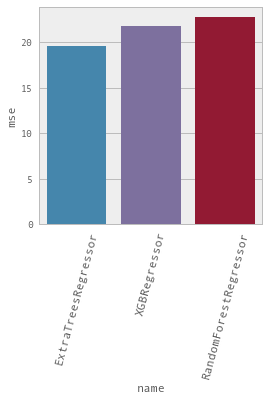

In [128]:
# Prepare Data
df = pd.read_csv("housingdata.csv", header=None, names = ['CRIM','INDUS','CHAS','NOX','RM','AGE','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
X = df.drop(["MEDV"], axis=1).values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df["MEDV"].values

# Spot Check Algorithms
y_pred = np.ones(len(y)) * y.mean()
baseline_mse = mean_squared_error(y, y_pred)
print("The baseline mse is {}".format(baseline_mse))

# Improve Results
models = []
models.append(("LR",linear_model.LinearRegression()))
models.append(("SGDRegressor",linear_model.SGDRegressor()))
models.append(("ElasticNet",linear_model.ElasticNet()))
models.append(("Ridge",linear_model.Ridge()))
models.append(("KNN",neighbors.KNeighborsRegressor()))
models.append(("DT",tree.DecisionTreeRegressor()))
models.append(("SVRLinear",svm.SVR(kernel='linear')))
models.append(("SVRPoly",svm.SVR(kernel='poly')))
models.append(("SVRRbf",svm.SVR(kernel='rbf')))
models.append(("SVRSigmoid",svm.SVR(kernel='sigmoid')))
bag_models = []
for name, model in models:
    bag_models.append(("Bagging" + name,ensemble.BaggingRegressor(model,max_samples=0.5, max_features=0.5)))
models = models + bag_models
models.append(("ExtraTreesRegressor",ensemble.ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_split=2, random_state=2)))
models.append(("AdaBoost",ensemble.AdaBoostRegressor(n_estimators=50, random_state=2)))
models.append(("GradientBoostingRegressor",ensemble.GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)))
models.append(("RandomForestRegressor",ensemble.RandomForestRegressor(n_estimators = 50, max_features="log2", min_samples_leaf=5, criterion="mse",bootstrap = True,random_state=2)))
models.append(("XGBRegressor",make_pipeline(StackingEstimator(estimator=linear_model.RidgeCV()),
XGBRegressor(learning_rate=0.1, max_depth=10, min_child_weight=13, n_estimators=40, nthread=1, subsample=0.55))))
names, mses = [], []
for name, model in models:
    cv_mse = cross_val_score(model, X, y, cv = KFold(n_splits=5, random_state=22), scoring='neg_mean_squared_error')
    names.append(name), mses.append(-1*cv_mse.mean())
models_df = pd.DataFrame({'name': names, 'mse': results}).sort_values(by=['mse']).iloc[0:3]
ax = sns.barplot(x="name", y="mse", data=models_df)
ax.set_xticklabels(models_df['name'], rotation=75, fontdict={'fontsize': 12})
plt.show()

Best Model: Pipeline(steps=[('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=75, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])
MSE: 
Best Features:


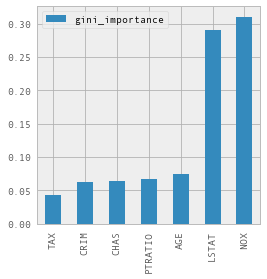

In [136]:
pipe_random_forest = Pipeline([('clf', ensemble.RandomForestRegressor(max_depth=None))])
param_grid = [{'clf__max_features': ['auto', 'sqrt', 'log2', 0.2],
               'clf__n_estimators': [25, 50, 75],
               'clf__min_samples_leaf': [1, 2, 3, 4],
               'clf__criterion': ['mse']}]
gs = GridSearchCV(estimator=pipe_random_forest,
                 param_grid=param_grid,
                 scoring='neg_mean_squared_error',
                 cv=5,
                 n_jobs=-1)
gs = gs.fit(X, y)
print("Best Model: {}".format(gs.best_estimator_))
print("MSE: ".format(-1*np.round(gs.best_score_,1)))
print("Best Features:")
model = gs.best_estimator_.steps[0][1]
X = df.drop(["MEDV"], axis=1)
feats = {}
for feature, importance in zip(X, model.feature_importances_):
    feats[feature] = importance
ginis = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_importance'})
ginis = ginis.query('gini_importance>=0.04')
ax = ginis.sort_values(by='gini_importance').plot(kind='bar', rot=90)
plt.show()